# **TensorFlow and TinyML** (Lorenza Nanni)
In this notebook, we use TensorFlow to build a simple ML model. After definyng our ML model, we will make it **tiny** using the TensorFLowLite library.

TensorFlow Lite, after applying techniques to make the model tiny, converts it into a binary file.

Once we have our Tiny ML model as a binary file, we can use TensorFlow Micro to deploy it on a MCU, such as an Arduino Machine.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os

In [ ]:
import pathlib

We can import the MNIST dataset for handwritten digit recognition.

In [ ]:
from tensorflow.keras.datasets import mnist


In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the images: normalize and reshape
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We can now build a CNN model

In [ ]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.9045 - loss: 0.3229
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - accuracy: 0.9859 - loss: 0.0462
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 26ms/step - accuracy: 0.9906 - loss: 0.0313
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - accuracy: 0.9939 - loss: 0.0200
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - accuracy: 0.9952 - loss: 0.0156


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9889 - loss: 0.0377
Accuracy: 99.07%


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


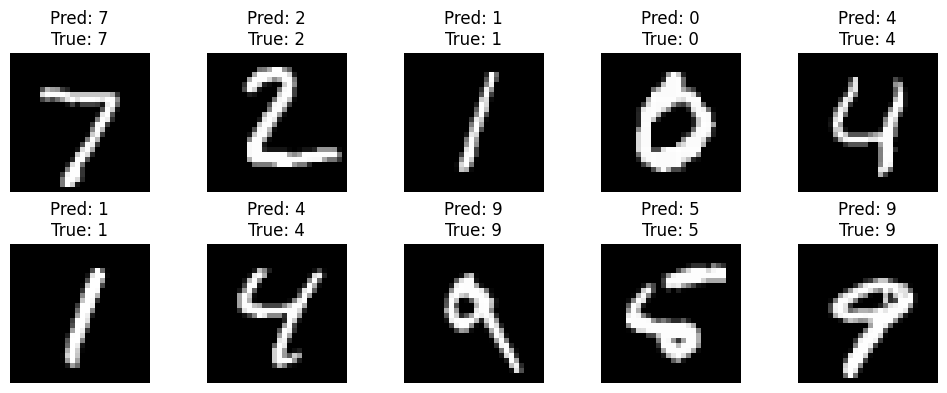

In [ ]:
# Make predictions on the test set
predictions = model.predict(test_images)

# Visualize some predictions
num_samples_to_plot = 10
plt.figure(figsize=(10, 4))

for i in range(num_samples_to_plot):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    predicted_class = np.argmax(predictions[i])
    plt.title(f'Pred: {predicted_class}\nTrue: {test_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **TensorFlowLite: How to make the model TINY**

we mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


we can check the model size once we save it


In [ ]:
model.save("/content/drive/MyDrive/TinyML/modelMNIST.keras")

In [ ]:
ModelSize = os.path.getsize("/content/drive/MyDrive/TinyML/modelMNIST.keras")
print(f"modelMNIST: {ModelSize/1000} kB")

modelMNIST: 1496.491 kB


Now we convert the ML model into tinyML, using TensorFlowLite.
For this example notebook, we are using the TenorFlow converter, which is provided to do optimization at the point of model conversion. The optimization this TF converter provides optimizas for bot latancy (i.e. time of inferencing) and for size (i.e. making the model "tiny"). This is the simplest way to optimize a model for deployment and it works quite well in many cases with simple models. However, if we are after a more complicated, specific model, and/or we are dealing with a specific scenario in a TinyML application, we might want to optimiza a model in a different way, e.g. focusing on the latancy time. This converter provided by TF makes the model "tiny" using a combination of Quantization and Pruning. Pruning means that the converter gets rid of the small weights in the model. Quantization changes the weights in the model from 32 bit floating points to 8 bit integer.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp29tl47wm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139280119205200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119209072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119204144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119211184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119210304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119212944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119202384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119214528: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
tflite_models_dir = pathlib.Path("/content/drive/MyDrive/TinyML/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"modelMNIST.tflite"
tflite_model_file.write_bytes(tflite_model)

491072

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT] # both pruning & post training quantization PTQ


In [ ]:
tflite_quant_model = converter.convert()


Saved artifact at '/tmp/tmpvnly6l6c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139280119205200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119209072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119204144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119211184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119210304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119212944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119202384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139280119214528: TensorSpec(shape=(), dtype=tf.resource, name=None)


Now we save the converted model

In [ ]:
tflite_model_quant_file = tflite_models_dir / "modelMNIST_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

130104

We can look at the dimension of the lite model

In [ ]:
ModelSizeQuant  = os.path.getsize("/content/drive/MyDrive/TinyML/modelMNIST_quant.tflite")
print(f"modelMNIST: {ModelSizeQuant/1000} kB")

modelMNIST: 130.104 kB


So we went from 1496.491 kB to 130.104 kB

We want to understand how much this impacts the model! To do so, we will load this model. Since it is now a binary file, we will need to interpret it to use it in a python notebook

# **Interpret the TinyML model**

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/TinyML/"+ 'modelMNIST_quant.tflite')
interpreter.allocate_tensors()


In [ ]:
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Test the model on random input data, this is to test the model is interpret correctly
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.09727778 0.00403591 0.16558346 0.00929661 0.00607114 0.0059968
  0.03976625 0.00217295 0.5766856  0.09311358]]


In [ ]:
# Test the model on real data
interpreter.set_tensor(input_details[0]['index'], test_images[0:1].astype("float32"))
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[7.8412912e-09 8.1799676e-08 4.5357388e-07 2.3861978e-06 1.2638299e-10
  4.5918941e-10 1.0434544e-13 9.9999428e-01 8.1315532e-09 2.7308624e-06]]


In [ ]:
# Evaluate the model on the test set
correct_predictions = 0
num_test_samples = len(test_images)

for i in range(num_test_samples):
    # Prepare the input data
    input_data = test_images[i:i+1]  # Shape (1, 28, 28, 1)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the inference
    interpreter.invoke()

    # Get the output and find the predicted class
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)

    # Count correct predictions
    if predicted_class == test_labels[i]:
        correct_predictions += 1

In [ ]:
# Calculate accuracy
accuracy = correct_predictions / num_test_samples
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 99.07%


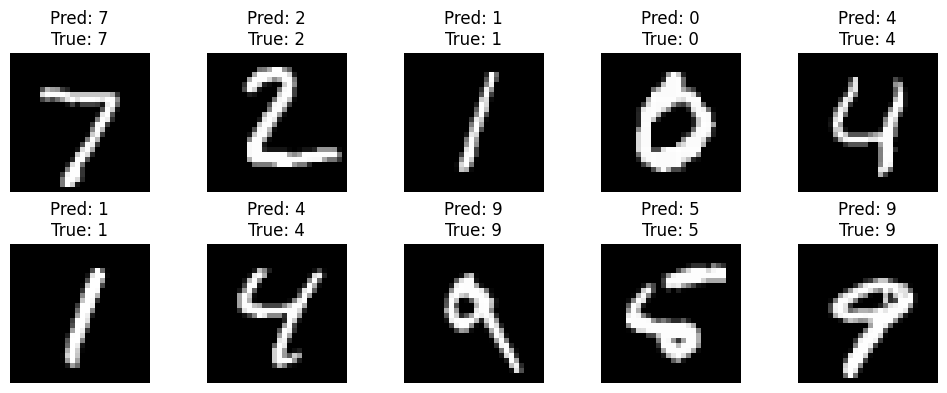

In [ ]:
predictions = []
for i in range(num_test_samples):
    input_data = test_images[i:i+1]
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(np.argmax(output_data))

# Visualize some predictions
num_samples_to_plot = 10
plt.figure(figsize=(10, 4))

for i in range(num_samples_to_plot):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predictions[i]}\nTrue: {test_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

So our model is still accurate. We can now deploy it on a MCU.
The deployment will require C++ code

## Here’s a basic example of how you would structure the code for inference using **TensorFlow Lite Micro**.

The following code is in C++ and cannot be run on this notebook.

In [ ]:
'''
// Include Necessary Libraries:

#include <Arduino.h>
#include <tensorflow/lite/model.h>
#include <tensorflow/lite/interpreter.h>
#include <tensorflow/lite/kernels/register.h>
#include <tensorflow/lite/micro/micro_interpreter.h>
#include <tensorflow/lite/schema/schema.h>
#include <tensorflow/lite/micro/micro_allocator.h>

// Include your model data
#include "modelMNIST_quant.h" // Include the compiled TFLite model

const int kTensorArenaSize = 2 * 1024;  // Size of the tensor arena
uint8_t tensor_arena[kTensorArenaSize];  // Buffer for tensors

// Constants for input and output tensor indices
const int kInputTensorIndex = 0;
const int kOutputTensorIndex = 1;

// Create a TfLite interpreter
tflite::MicroInterpreter interpreter(model_data, tensor_arena, kTensorArenaSize, resolver, &error_reporter);

// Initialize function
void setup() {
    Serial.begin(115200);

    // Allocate tensors
    interpreter.AllocateTensors();

    // Get pointers to input and output tensors
    TfLiteTensor* input = interpreter.input(kInputTensorIndex);
    TfLiteTensor* output = interpreter.output(kOutputTensorIndex);

    // Here, we use dummy data (a blank image of zeros) as an example
    uint8_t input_data[28 * 28] = {0}; // Example: input image (28x28 pixels)
    memcpy(input->data.uint8, input_data, sizeof(input_data));

    // Run inference
    interpreter.Invoke();

    // Process output
    float* output_data = output->data.f;
    int predicted_class = std::distance(output_data, std::max_element(output_data, output_data + 10));

    // Print the predicted class
    Serial.print("Predicted class: ");
    Serial.println(predicted_class);
}

void loop() {
    // Normally, you might want to continuously read new data and run inference
}

'''

'\n// Include Necessary Libraries:\n\n#include <Arduino.h>\n#include <tensorflow/lite/model.h>\n#include <tensorflow/lite/interpreter.h>\n#include <tensorflow/lite/kernels/register.h>\n#include <tensorflow/lite/micro/micro_interpreter.h>\n#include <tensorflow/lite/schema/schema.h>\n#include <tensorflow/lite/micro/micro_allocator.h>\n\n// Include your model data\n#include "modelMNIST_quant.h" // Include the compiled TFLite model\n\nconst int kTensorArenaSize = 2 * 1024;  // Size of the tensor arena\nuint8_t tensor_arena[kTensorArenaSize];  // Buffer for tensors\n\n// Constants for input and output tensor indices\nconst int kInputTensorIndex = 0;\nconst int kOutputTensorIndex = 1;\n\n// Create a TfLite interpreter\ntflite::MicroInterpreter interpreter(model_data, tensor_arena, kTensorArenaSize, resolver, &error_reporter);\n\n// Initialize function\nvoid setup() {\n    Serial.begin(115200);\n    \n    // Allocate tensors\n    interpreter.AllocateTensors();\n\n    // Get pointers to input 